# Using GOTO-tile to plot grids

---
## Plotting SkyGrids

The `gototile.grid.SkyGrid` class has a `plot()` method, which is a simple way to output a plot and has many formatting options.

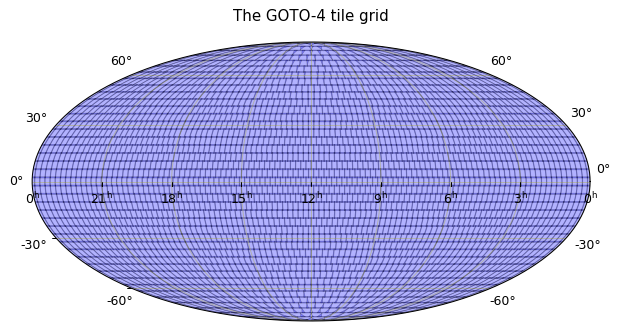

In [1]:
from gototile.grid import SkyGrid
grid = SkyGrid.from_name('GOTO-4')
grid.plot(title='The GOTO-4 tile grid')

However, sometimes you want more control over the plot. Which is why I've added the `plot_tiles()` method, which will only plot the basic grid on the given axis (`plot()` uses this internally).

Here's a basic example:

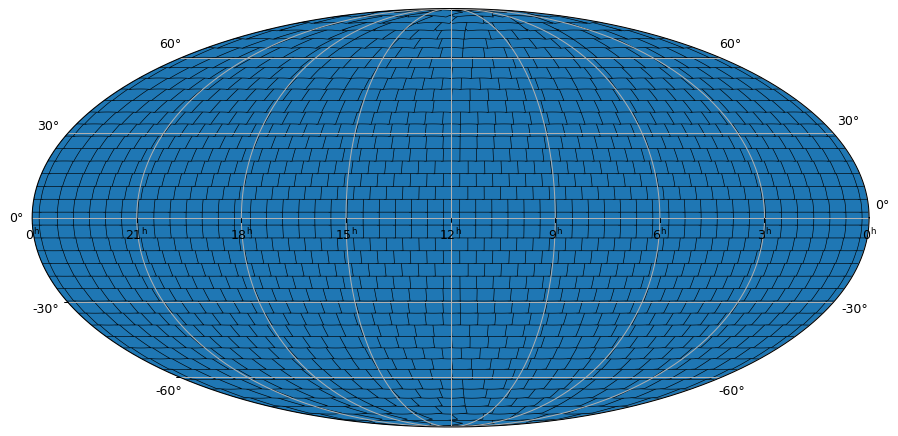

In [2]:
from matplotlib import pyplot as plt

# Create a new grid
grid = SkyGrid.from_name('GOTO-8p')

# Create a blank figure
fig = plt.figure(figsize=(12, 8), dpi=90)

# Create the axes, using the astro Mollweide projection
# (see later for more projection options)
axes = plt.axes(projection='astro hours mollweide')

# Display the RA/Dec grid lines
axes.grid()

# Add the tiles to the axes
grid.plot_tiles(axes)

# Show the figure
plt.show()

Aside from having a slightly different default format, plotting the tiles in this way adds a lot more options for customisation. In the following section I present some examples of making plots using GOTO-tile.

---
## Example plots

### Plotting data arrays

A common case is that you have some data relating to each grid tile, for instance the number of times each tile was observed over a given period, and you want to colour the tiles in the plot using those values.

First we'll produce some random data:

In [3]:
from numpy import random

# Create some random data
data = random.random(grid.ntiles)

# Set the values all tiles below 30deg dec to None
data[grid.coords.dec.deg < -30] = None

Now we'll make a plot with the tiles coloured. Note any formatting arguments to the `plot_tiles` function after the axes gets passed to a `matplotlib.collections.PatchCollection` comprising the tile polygons, so look at the MPL documentation for the different options. Here we use the `array=` argument to pass an array of data, which is the same length as the number of tiles.

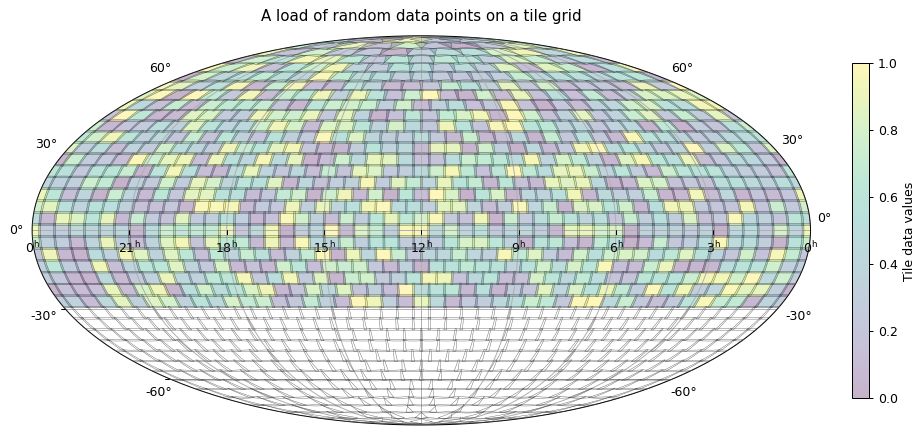

In [4]:
# Create the figure and axes
fig = plt.figure(figsize=(12, 8), dpi=90)
axes = plt.axes(projection='astro hours mollweide')
axes.grid()

# Plot the tiles, using the `array` argument to apply to the tile fill colours
# Note we make the tiles slightly transparent to show the overlap
tiles = grid.plot_tiles(axes, array=data, ec='none', alpha=0.3, zorder=1)

# Plot the tile edges on top as solid lines
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.3, zorder=1.5)

# Add a colourbar
# (note you have to pass it the tiles, and the limits are set on the tiles not the bar)
cbar = fig.colorbar(tiles, ax=axes, fraction=0.02, pad=0.05, label='Tile data values')
tiles.set_clim(0, 1)

# Add a title, shifted up slightly to look better
axes.set_title('A load of random data points on a tile grid', y=1.02)

# Show the figure
plt.show()

### Setting formats for specific tiles

Formatting individual tiles needs to be done at the same time as the rest, unfortunately you can't easily do something like `tiles[333].facecolor='red'`. It is doable, you just need to be clever when creating the lists of colours.

Here we have some specific tiles we want to highlight, using their GOTO-tile IDs:

In [5]:
red_tiles = ['T0042', 'T1000', 'T1234']
blue_tiles = ['T0124', 'T0987', 'T1111']

Now we need to create a list that is the same length as the total number of tiles, with the correct formatting for the ones we want to highlight. You could do this through list comprehension: 

In [6]:
colours = ['red' if tilename in red_tiles else 'blue' if tilename in blue_tiles else 'grey' for tilename in grid.tilenames]
lws = [1 if tilename in red_tiles + blue_tiles else 0.3 for tilename in grid.tilenames]

... or through masking Numpy arrays:

In [7]:
import numpy as np

colours = np.array(['grey'] * grid.ntiles)
lws = np.array([0.3] * grid.ntiles)

red_indexes = [np.where(np.array(grid.tilenames)==t)[0][0] for t in red_tiles]
blue_indexes = [np.where(np.array(grid.tilenames)==t)[0][0] for t in blue_tiles]

colours[red_indexes] = 'red'
colours[blue_indexes] = 'blue'
lws[red_indexes] = 1
lws[blue_indexes] = 1

These both produce the same output, and while list comprehension is a lot shorter here array masking might be more useful generally so I decided to include it too.

Once the formatting lists/arrays are created they can be plotted very simply:

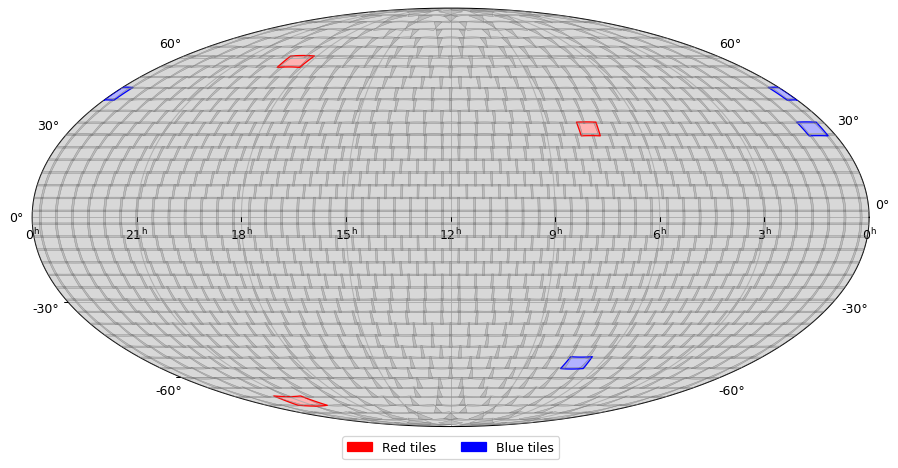

In [8]:
# Create the figure and axes
fig = plt.figure(figsize=(12, 8), dpi=90)
axes = plt.axes(projection='astro hours mollweide')
axes.grid()

# Plot the tiles and edges using the format arrays
grid.plot_tiles(axes, fc=colours, ec='none', alpha=0.3, zorder=1)
grid.plot_tiles(axes, fc='none', ec=colours, lw=lws, zorder=1.5)

# Add a legend
from matplotlib.patches import Patch
red_legend = Patch(facecolor='red', edgecolor='red', linewidth=1, label='Red tiles')
blue_legend = Patch(facecolor='blue', edgecolor='blue', linewidth=1, label='Blue tiles')
plt.legend(handles=[red_legend, blue_legend], loc='center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Show the figure
plt.show()

Note that one of the highlighted tiles overlaps the RA=0 meridian, and both halves are coloured as you'd expect. That was a lot harder to get working than than you'd think, but it works now so you don't need to worry about it.

### Plotting coordinates and zoom plots

The astro axes used here are part of the LIGO skymap package, `ligo.skymap.plot`. The package is installed with GOTO-tile, mostly for plotting skymaps, but they are also very useful for the grids here. For more information see https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html.

The module provides multiple other projections, the most useful are `astro hours mollweide`, `astro zoom` and `astro globe`. We'll use `zoom` in this example and both `zoom` and `globe` in the next example.

Let's say we want to add some coordinates to our plot. The axes provided by the LIGO package are compatible with Astropy, so we can just create a SkyCoord.

In [9]:
from astropy.coordinates import SkyCoord
coordinates = SkyCoord('20h00m 60d45m')

We might want to find which tiles on the GOTO grid those coordinates fall within. There's a helpful method on the `SkyGrid` class to do just that, which accounts for the fact that the grid tiles have a reasonable overlap (and in this case we want every tile the coordinates are within, not just the closest one).

In [10]:
tilenames = grid.get_tile(coordinates, overlap=True)
tilenames

['T1235', 'T1236', 'T1260']

Now we know that the coordinates fall in the intersecting area of those three tiles. Let's try plotting the grid zoomed in on that position, marking the coordinates and the three tiles they are within. 

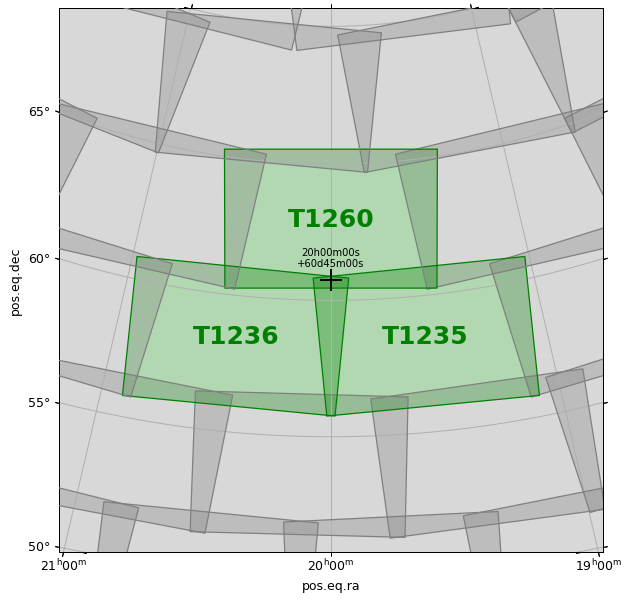

In [11]:
# Create the figure
fig = plt.figure(figsize=(12, 8), dpi=90)

# Create the axes using the `astro zoom` projection, centred on the coordinates and with
# a 10 degree radius.
axes = plt.axes(projection='astro zoom', center=coordinates, radius='10 deg')
axes.grid()

# Plot the coordinates on the grid
# Note need to transform into the same projection as the axes
transform = axes.get_transform('world')
axes.scatter(coordinates.ra.value, coordinates.dec.value,
             s=300, c='black', marker='+', zorder=9,
             transform=transform,
             )

# Add a text label for the coordinates
label = coordinates.to_string('hmsdms').replace(' ', '\n') + '\n'
axes.text(coordinates.ra.value, coordinates.dec.value, label,
          ha='center', va='bottom', fontsize=8, zorder=12,
          transform=transform,
          )

# Plot the tiles and edges, highlighting the tiles that contain the coordinates
colours = ['green' if tilename in tilenames else '0.5' for tilename in grid.tilenames]
grid.plot_tiles(axes, fc=colours, ec='none', alpha=0.3, zorder=1)
grid.plot_tiles(axes, fc='none', ec=colours, lw=1, zorder=1.5)

# Add text lables for the three highlighted tiles
for name in tilenames:
    index = np.where(np.array(grid.tilenames) == name)[0][0]
    coord = grid.coords[index]
    plt.text(coord.ra.deg, coord.dec.deg, name,
             color='green', weight='bold', fontsize=20,
             ha='center', va='center', clip_on=True,
             transform=transform)

# Show the figure
plt.show()

### Plotting tile statistics and globe plots

Here's a more complicated case study: plotting all the points on a HEALPix grid coloured by the number of tiles they fall within. I won't go into detail about how we calculate this, or how I had to hack the matplotlib colourbar, but instead I'll just show off the globe projection as well as another zoom looking at the north pole of the sphere.

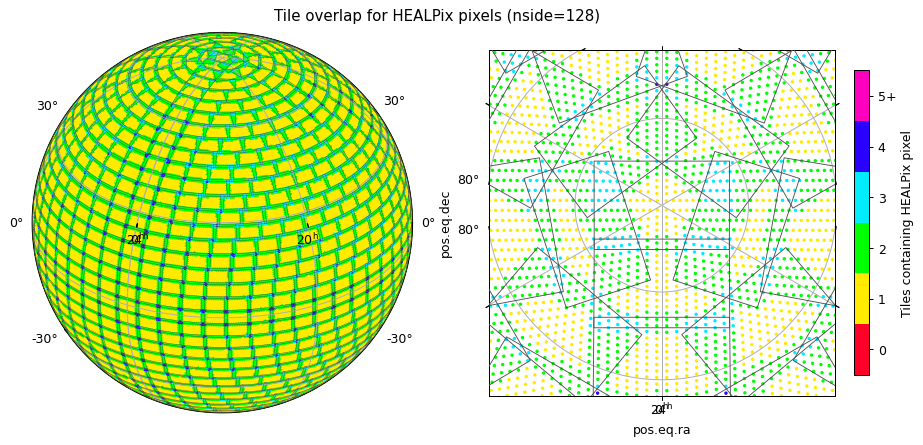

In [12]:
from gototile.skymaptools import pix2coord
from matplotlib.colors import BoundaryNorm

fig = plt.figure(figsize=(12, 8), dpi=90)

# Create the first subplot with a globe projection
axes = plt.subplot(121, projection='astro globe', center='22h 30d')
axes.grid()

# Plot just the tile edges
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.3, zorder=1.5)

# Get count statistics and the coordinates of each HEALPix pixel to plot
nside = 2**7
count = grid._get_pixel_count(nside)
coords = pix2coord(nside, range(len(count)), nest=True)

# Create a new colour map
# [see https://stackoverflow.com/questions/14777066]
cmap = plt.cm.get_cmap('gist_rainbow')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom', cmaplist, cmap.N)

# Normalize to a maximum of 5
k = 5
norm = BoundaryNorm(np.linspace(0, k + 1, k + 2), cmap.N)

# Plot the points using the colourbar and normalisation
transform = axes.get_transform('world')
points = axes.scatter(coords.ra.deg, coords.dec.deg,
                      transform=transform,
                      s=1, c=count,
                      cmap=cmap, norm=norm,
                      zorder=0)

# Create the second subplot as a zoom plot looking at the pole
axes2 = plt.subplot(122, projection='astro zoom', center='0h 89d', radius='10 deg')
axes2.grid()

# Plot the tiles and points again
grid.plot_tiles(axes2, fc='none', ec='0.3', lw=0.7, zorder=1.5)
transform = axes2.get_transform('world')
points = axes2.scatter(coords.ra.deg, coords.dec.deg,
                      transform=transform,
                      s=3, c=count,
                      cmap=cmap, norm=norm,
                      zorder=0)

# Add a colorbar
cb = fig.colorbar(points, ax=axes2, fraction=0.04, pad=0.05, label='Tiles containing HEALPix pixel')
tick_labels = np.arange(0, k + 1, 1)
tick_location = tick_labels + 0.5
tick_labels = [str(label) for label in tick_labels]
tick_labels[-1] = str(tick_labels[-1] + '+')
cb.set_ticks(tick_location)
cb.set_ticklabels(tick_labels)

# Add a supertitle over both subplots
fig.suptitle(f'Tile overlap for HEALPix pixels (nside={nside})', y=0.8)

plt.show()

In this case you can see that most of the grid is within one tile, while those points in the overlapping regions can be within two, three or four. Ideally you'd want to use a higher-resolution HEALPix grid for the plot on the right, but I thought it was interesting to show the individual points. If you want the exact statistics you can use the `grid.get_stats()` method, which says that just over 55% of the grid is within one tile (the important thing is that there are no pixels within 0 tiles!):

In [13]:
grid.get_stats(nside)

in_tiles,npix,freq
int64,int64,float64
1,108240,55.05%
2,68360,34.77%
3,17352,8.83%
4,2656,1.35%


### Plotting skymaps

One of the reasons we have a grid is the framework to map skymaps onto, and see the probability contained within each tile.

I already show off some skymap plots in the `skymap` notebook, using the `SkyGrid.plot()` method. Here I'll show how to produce the same thing manually with `plot_tiles()`.

First we need to download the skymap, and apply it to the grid.

In [14]:
from gototile.skymap import SkyMap

url = 'https://gracedb.ligo.org/api/superevents/S190521r/files/bayestar.fits.gz'
skymap = SkyMap.from_fits(url)

grid.apply_skymap(skymap)
grid.get_table()

tilename,ra,dec,prob
,deg,deg,
str5,float64,float64,float64
T0001,0.0,-90.0,3.3400594548131565e-05
T0002,0.0,-85.5,6.139466735544498e-05
T0003,72.0,-85.5,1.8555869490356336e-05
T0004,144.0,-85.5,5.495349954102466e-07
T0005,216.0,-85.5,2.3241084882629337e-05
T0006,288.0,-85.5,4.828420150390055e-05
...,...,...,...
T1321,0.0,85.5,1.2162335037069236e-47


Now we can just plot the tile contained probabilities on the grid, which just uses the `array=` argument used with the random data example.

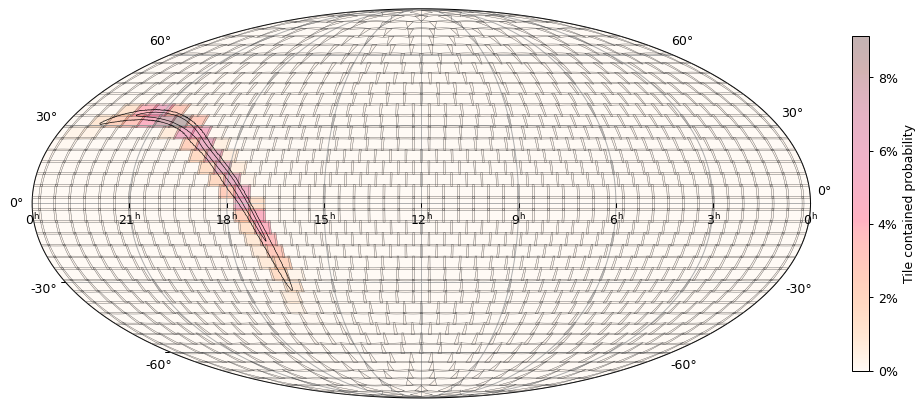

In [15]:
fig = plt.figure(figsize=(12, 8), dpi=90)
axes = plt.axes(projection='astro hours mollweide')
axes.grid()

# Plot the tiles, passing the tile probabilities to the `array` argument 
tiles = grid.plot_tiles(axes, array=grid.probs, ec='none', alpha=0.3, zorder=1)
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.3, zorder=1.5)

# Also plot the skymap contours, which uses a function on the axes added by the LIGO module
axes.contour_hpx(grid.skymap.contours / max(grid.skymap.contours),
                 nested=grid.skymap.is_nested,
                 levels=[0.5, 0.9],
                 colors='black', linewidths=0.5, zorder=99,)

# We want to use the "official" LIGO colourmap, which is called 'cylon'
tiles.set_cmap('cylon')

# Add the colourbar, formatting as a percentage
fig.colorbar(tiles, ax=axes, fraction=0.02, pad=0.05, label='Tile contained probability',
            format=lambda x, _: f'{x:.0%}')

# Show the figure
plt.show()

Just for good measure here's the function used within `SkyMap.plot()` to plot HEALPix skymaps: `skymap.healpix.plot()` (note that you pass it the axes in the same way as `skygrid.plot_tiles()`). The zoom inset is taken from https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html#insets.

There is also the function `healpix.plot_grid()` which will outline all of the HEALPix pixels, but it's incredibly slow and inneficient for such a high-res multi-order skymap so I didn't include it here (the output is hown in the `skymap` notebook).

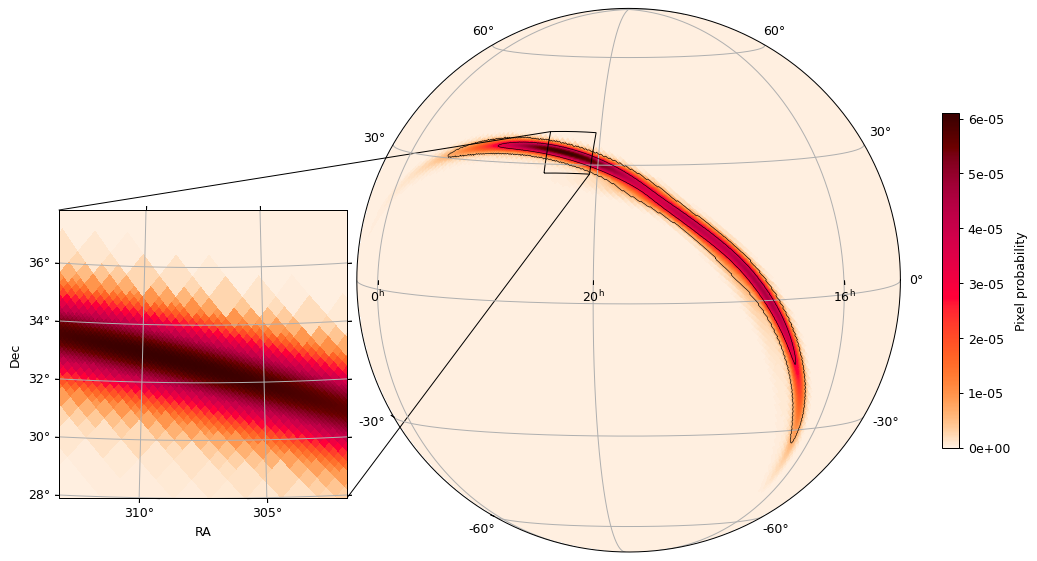

In [16]:
fig = plt.figure(figsize=(12, 8), dpi=90)
axes = plt.axes(projection='astro globe', center='19h30m 5d')
axes.grid()

# Plot the HEALPix skymap data
image, _ = skymap.healpix.plot(axes, rasterize=False, cmap='cylon', cbar=False)

# Plot the skymap contours
axes.contour_hpx(grid.skymap.contours / max(grid.skymap.contours),
                 nested=grid.skymap.is_nested,
                 levels=[0.5, 0.9],
                 colors='black', linewidths=0.5, zorder=99,)

# Add the colourbar, formatting as a percentage
fig.colorbar(image, ax=axes, fraction=0.02, pad=0.05, label='Pixel probability',
            format=lambda x, _: f'{x:.0e}')

# Zoom plot
axes_zoom = plt.axes([0.0, 0.2, 0.4, 0.4], projection='astro degrees zoom', center='20h30m 33d', radius='5 deg')
axes_zoom.grid()

# Plot the HEALPix skymap data, again
skymap.healpix.plot(axes_zoom, rasterize=False, cmap='cylon', cbar=False)

# Improve on the default axis labels
axes_zoom.set_xlabel('RA')
axes_zoom.set_ylabel('Dec')

# Connect the plot
axes.mark_inset_axes(axes_zoom)
axes.connect_inset_axes(axes_zoom, 'upper left')
axes.connect_inset_axes(axes_zoom, 'lower right')

# Show the figure
plt.show()